for iter3A, turn down the learning rate from 1e-6 to 1-e7 & increase batch size from 64 to 512;
let's see if it works.

--------------------- 


for iter2A (RunModel_IntervalTracks_to_hists_19April2023_HDplusUNet100A_U32_FP16_iter2A_10epochs-1em6_JpsiPhiMagDown_Data_asymm2p5), start from epoch 47 of iter1A (better performance than final epoch) and reduce lr to 1e-6.

--------------------------

Create

  RunModel_IntervalTracks_to_hists_19April2023_HDplusUNet100A_U32_FP16_iter1A_50epochs-4em6_JpsiPhiMagDown_Data_asymm2p5

from iter0A; change # of epochs from 10 to 50;
start with iter0A weights;
reduce learning rate from 8e-6 to4e-6.

-----------------------------------------------------

RunModel_IntervalTracks_to_hists_19April2023_HDplusUNet100A_U32_FP16_iter0A_10epochs-2em5_JpsiPhiMagDown_Data_asymm2p5

is derived from

  RunModel_IntervalTracks_to_hists_17April2023_HDplusUNet100A_FP16_iter0A_alt_lossAA-10epochs-2em5_JpsiPhiMagDown_Data_Data_asymm2p5-Copy1


The only differences are that it will use

  nUNetChannels= 32
  
in place of 

  nUNetChannels= 16
  
and training_kde_FP16_all_training to get validation sample costs

.AND. learning rate = 8e-6 rather than 2e-5 as a first attempt with 2e-5 had training costs
bounding around more than I had expected.

----------------------------------

RunModel_IntervalTracks_to_hists_17April2023_HDplusUNet100A_FP16_iter0_alt_lossAA-2epochs-2em5_JpsiPhiMagDown_Data_Data_asymm2p5

is derived from

  RunModel_IntervalTracks_to_hists_16April2023_HDplusUNet100A_test-alt_lossAA-2epochs-2em4_fullLHCbMC_All_altData_asymm2p5-Copy1

The latter uses a "flattened" version of Will's UNet100A model to begin to learn t2hists with
the parameters for the fully connected layers taken from an earlier t2hists model that worked
well.

The results were

Epoch 0: train=0.115231, train_eval=0.0672449, val=0.066518, took 646.64 s

Epoch 1: train=0.0592411, train_eval=0.0646583, val=0.0641429, took 639.26 s


  ---> the goal of this notebook is to execute the same algorithm with Automatic
       Mixed Precision generating FP16 weights and biases.
       
Earlier attempts with Will's original UNet100A model failed; this may have been due
to using batch normalization is a "nested" child of the model. It is possible
that using a flattened version of the model will resolve this problem.


In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


In [2]:
import numpy as np
##  testing the np.floor and np.int_ methods as they seem to fail in a method used below
##  from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
print("np.version.version = ",np.version.version)
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
aFloor = np.floor(a)
print("a = ",a)
print("a.shape = ",a.shape)
print("aFloor = ",aFloor)
print("aFloor.shape = ",aFloor.shape)
aFloorInt = np.int_(aFloor)
print("aFloorInt = ",aFloorInt)

np.version.version =  1.23.5
a =  [-1.7 -1.5 -0.2  0.2  1.5  1.7  2. ]
a.shape =  (7,)
aFloor =  [-2. -2. -1.  0.  1.  1.  2.]
aFloor.shape =  (7,)
aFloorInt =  [-2 -2 -1  0  1  1  2]


This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [3]:
!nvidia-smi

Thu Apr 20 14:21:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   29C    P8    22W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch

import pandas as pd
testing = pd.__version__ 
print('testing = ',testing)
pd_major, pd_minor, pd_patch = [int(x, 10) for x in testing.split('.')]
print('pd_major, pd_minor, pd_patch  = ',pd_major, pd_minor, pd_patch)


# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

numpy.version.version =  1.23.5
testing =  2.0.0
pd_major, pd_minor, pd_patch  =  2 0 0


### Set up local parameters

In [5]:
n_epochs = 50

# Name is the output file name


##  201019  mds
folder = '19April2023_t2hists_HDplusUNet100A_U32_FP16_iter2A_10epochs_1em6_JpsiPhiMagDown_Data_asymm2p5'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)

## batch_size = 64 seems to use 20 GB on 3090,
## so set batch_size = 16 so we can run on a 2080Ti
##  batch_size 16 still seems to require commenting out
##  device=device, and one epoch takes >900 seconds
##  compared to 120 seconds with batch_size = 64 on 3090
##  so try batch_size = 64 again

#  230420 increase batch sizefrom 64 to 512; it will probably 
#  fit into the 3090 memory, and may smooth out some of the
#  stochastic gradient descent fluctuations
# Size of batches
batch_size = 512
# How fast to learn
learning_rate = 1e-7

Make the output directory if it does not exist:

In [6]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [7]:
from model.collectdata_kde_Ellipsoids_MinBiasMagDown_14Nov import collect_t2kde_data as collect_t2kde_data_down
from model.collectdata_kde_Ellipsoids_MinBiasMagUp_14Nov import collect_t2kde_data as collect_t2kde_data_up
## the next line brings in a new method to read in "prepared" data
from model.collectdata_kde_Ellipsoids_Arrays import collect_t2kde_arrays

## 220714 mds 
## interval_kde_loss_Ba is derived from kde_loss_Ba, modified for 100-bin intervals
## looks like it returns average loss per bin, so costs may be directly
## comparable to original DirtyDozen
##from model.interval_kde_loss_Ba import Loss

## alt_loss_AAa requires not-NaN for both target and predicted values
from model.alt_loss_AAa import Loss

## this HDplusUNet100A model is a flattened version of the original
## that uses Will's methods
from model. models_16April2023_kde_plus import TrackIntervalsToKDE_HDplusUNet100A as Model


##from model.training_kde import trainNet, select_gpu, Results  ## used for full float32 arithmetic

## training_kde_FP16 uses torch.autocast to cast conv1d, conv_transpose1d, and linear to FP16.
## see https://pytorch.org/docs/stable/amp.html#cuda-ops-that-can-autocast-to-float16
from model.training_kde_FP16_all_training import trainNet, select_gpu, Results

from model.plots import dual_train_plots, replace_in_ax

In [8]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [9]:
##device = "cuda"
device = select_gpu(2)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 NVIDIA GeForce RTX 3090


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [11]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

latentChannels = 8
nUNetChannels= 32  ## down from 64 with UNet100

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,latentChannels=latentChannels,n=nUNetChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa


ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct <6:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
##loss = Loss(epsilon=3e-6)
loss = Loss(epsilon=1e-5,coefficient=2.5)

ct, child =  0    Linear(in_features=9, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  0 params
ct, child =  1    Linear(in_features=20, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  1 params
ct, child =  2    Linear(in_features=20, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  2 params
ct, child =  3    Linear(in_features=20, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  3 params
ct, child =  4    Linear(in_features=20, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  4 params
ct, child =  5    Linear(in_features=20, out_features=800, bias=True)
     About to set param.requires_grad=False for ct =  5 params
ct, child =  6    Dropout(p=0.25, inplace=False)
ct, child =  7    ReLU()
ct, child =  8    BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ct, child =  9    Conv1d(8, 32, kern

Let's move the model's weight matricies to the GPU:

In [12]:
model = model.to(device)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
##updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
##updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
##updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
##updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
##updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

output =  ML/19April2023_t2hists_HDplusUNet100A_U32_FP16_iter2A_10epochs_1em6_JpsiPhiMagDown_Data_asymm2p5
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6A.weight
index, k =   11    layer6A.bias
index, k =   12    bn1.weight
index, k =   13    bn1.bias
index, k =   14    bn1.running_mean
index, k =   15    bn1.running_var
index, k =   16    bn1.num_batches_tracked
index, k =   17    downConv_L1.weight
index, k =   18    downConv_L1.bias
index, k =   19    downConv_L2.weight
index, k =   20    downConv_L2.bias
index, k =   21    bn2.weight
index, k =   22    bn2.bias
index, k =   23    bn2.running_mean
index, k =   24    bn2.running_var
index, k =   25    bn2.num_batches_tracked
index, k =

In [15]:

##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


##pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3_220.pyt')

##  the next model had fluctuations near the end, but the final epoch is within striking distance of the lowest cost
##pretrained_dict = torch.load('ML/10September_t2hists_HDplusUNet100_iter0C_5epochs_1em3_fullLHCbMC_scrubbedData/10September_t2hists_HDplusUNet100_iter0C_5epochs_1em3_fullLHCbMC_scrubbedData_final.pyt')
##pretrained_dict = torch.load('ML/10September_t2hists_HDplusUNet100_iter1C_5epochs_20em3_fullLHCbMC_scrubbedData/10September_t2hists_HDplusUNet100_iter1C_5epochs_20em3_fullLHCbMC_scrubbedData_final.pyt')
##pretrained_dict = torch.load('ML/10September_t2hists_HDplusUNet100_iter3C_10epochs_1em3_fullLHCbMC_scrubbedData/10September_t2hists_HDplusUNet100_iter3C_10epochs_1em3_fullLHCbMC_scrubbedData_final.pyt')
##pretrained_dict = torch.load('ML/10September_t2hists_HDplusUNet100_iter4C_75epochs_1em3_fullLHCbMC_scrubbedData/10September_t2hists_HDplusUNet100_iter4C_75epochs_1em3_fullLHCbMC_scrubbedData_7.pyt')
##pretrained_dict = torch.load('ML/11September_t2hists_HDplusUNet100_iter5C_10epochs_1em4_fullLHCbMC_scrubbedData/11September_t2hists_HDplusUNet100_iter5C_10epochs_1em4_fullLHCbMC_scrubbedData_final.pyt')
##pretrained_dict = torch.load('ML/11September_t2hists_HDplusUNet100_iter6C_10epochs_1em4_fullLHCbMC_scrubbedData_moreData/11September_t2hists_HDplusUNet100_iter6C_10epochs_1em4_fullLHCbMC_scrubbedData_moreData_final.pyt')
pretrained_dict = torch.load('ML/25September_t2hists_HDplusUNet100A_iter1_10epochs_2em4_fullLHCbMC_All_moreData_asymm2p5/25September_t2hists_HDplusUNet100A_iter1_10epochs_2em4_fullLHCbMC_All_moreData_asymm2p5_final.pyt')
pretrained_dict = torch.load('ML/25September_t2hists_HDplusUNet100A_iter2_10epochs_2em4_fullLHCbMC_All_moreData_asymm2p5/25September_t2hists_HDplusUNet100A_iter2_10epochs_2em4_fullLHCbMC_All_moreData_asymm2p5_4.pyt')
pretrained_dict = torch.load('ML/19April2023_t2hists_HDplusUNet100A_U32_FP16_iter0A_10epochs_8em6_JpsiPhiMagDown_Data_asymm2p5/19April2023_t2hists_HDplusUNet100A_U32_FP16_iter0A_10epochs_8em6_JpsiPhiMagDown_Data_asymm2p5_final.pyt')
pretrained_dict = torch.load('ML/19April2023_t2hists_HDplusUNet100A_U32_FP16_iter1A_10epochs_4em6_JpsiPhiMagDown_Data_asymm2p5/19April2023_t2hists_HDplusUNet100A_U32_FP16_iter1A_10epochs_4em6_JpsiPhiMagDown_Data_asymm2p5_47.pyt')
pretrained_dict = torch.load('ML/19April2023_t2hists_HDplusUNet100A_U32_FP16_iter2A_10epochs_1em6_JpsiPhiMagDown_Data_asymm2p5/19April2023_t2hists_HDplusUNet100A_U32_FP16_iter2A_10epochs_1em6_JpsiPhiMagDown_Data_asymm2p5_final.pyt')

print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)


 
  for pretrained_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6A.weight
index, k =   11    layer6A.bias
index, k =   12    bn1.weight
index, k =   13    bn1.bias
index, k =   14    bn1.running_mean
index, k =   15    bn1.running_var
index, k =   16    bn1.num_batches_tracked
index, k =   17    downConv_L1.weight
index, k =   18    downConv_L1.bias
index, k =   19    downConv_L2.weight
index, k =   20    downConv_L2.bias
index, k =   21    bn2.weight
index, k =   22    bn2.bias
index, k =   23    bn2.running_mean
index, k =   24    bn2.running_var
index, k =   25    bn2.num_batches_tracked
index, k =   26    downConv_L3.weight
index, k =   27    downConv_L3.bias
index, k =   28    bn3.weight
inde

<All keys matched successfully>

##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [16]:

##train_loader_A = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_arrays('dataAA/pv_HLT1CPU_JpsiPhiMagDown_12Dec_t2hists_Arrays_allEvents.npy',                                 
                            batch_size=batch_size,
                            pin_memory=True,
##                            device=device,
                           )

## train_loader_B = collect_t2kde_arrays('dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_training_allEvents.npy',                                  
##                            batch_size=batch_size,
##                            pin_memory=True,
##                            device=device,
##                           )
                            

# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_arrays('dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation_allEvents.npy',
                            batch_size=batch_size,
                            pin_memory=True,
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
##                          device=device,
                           )

XY_file =  dataAA/pv_HLT1CPU_JpsiPhiMagDown_12Dec_t2hists_Arrays_allEvents.npy
Loaded dataAA/pv_HLT1CPU_JpsiPhiMagDown_12Dec_t2hists_Arrays_allEvents.npy in 19.97 s
outer loop X.shape =  (3567280, 9, 250)
Constructing 3567280 event dataset took 5.239 s
x_t.shape =  torch.Size([3567280, 9, 250])
x_t.shape[0] =  3567280
x_t.shape[1] =  9
y_t.shape =  torch.Size([3567280, 100])
XY_file =  dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation_allEvents.npy
Loaded dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation_allEvents.npy in 2.591 s
outer loop X.shape =  (452560, 9, 250)
Constructing 452560 event dataset took 0.422 s
x_t.shape =  torch.Size([452560, 9, 250])
x_t.shape[0] =  452560
x_t.shape[1] =  9
y_t.shape =  torch.Size([452560, 100])


<IPython.core.display.Javascript object>


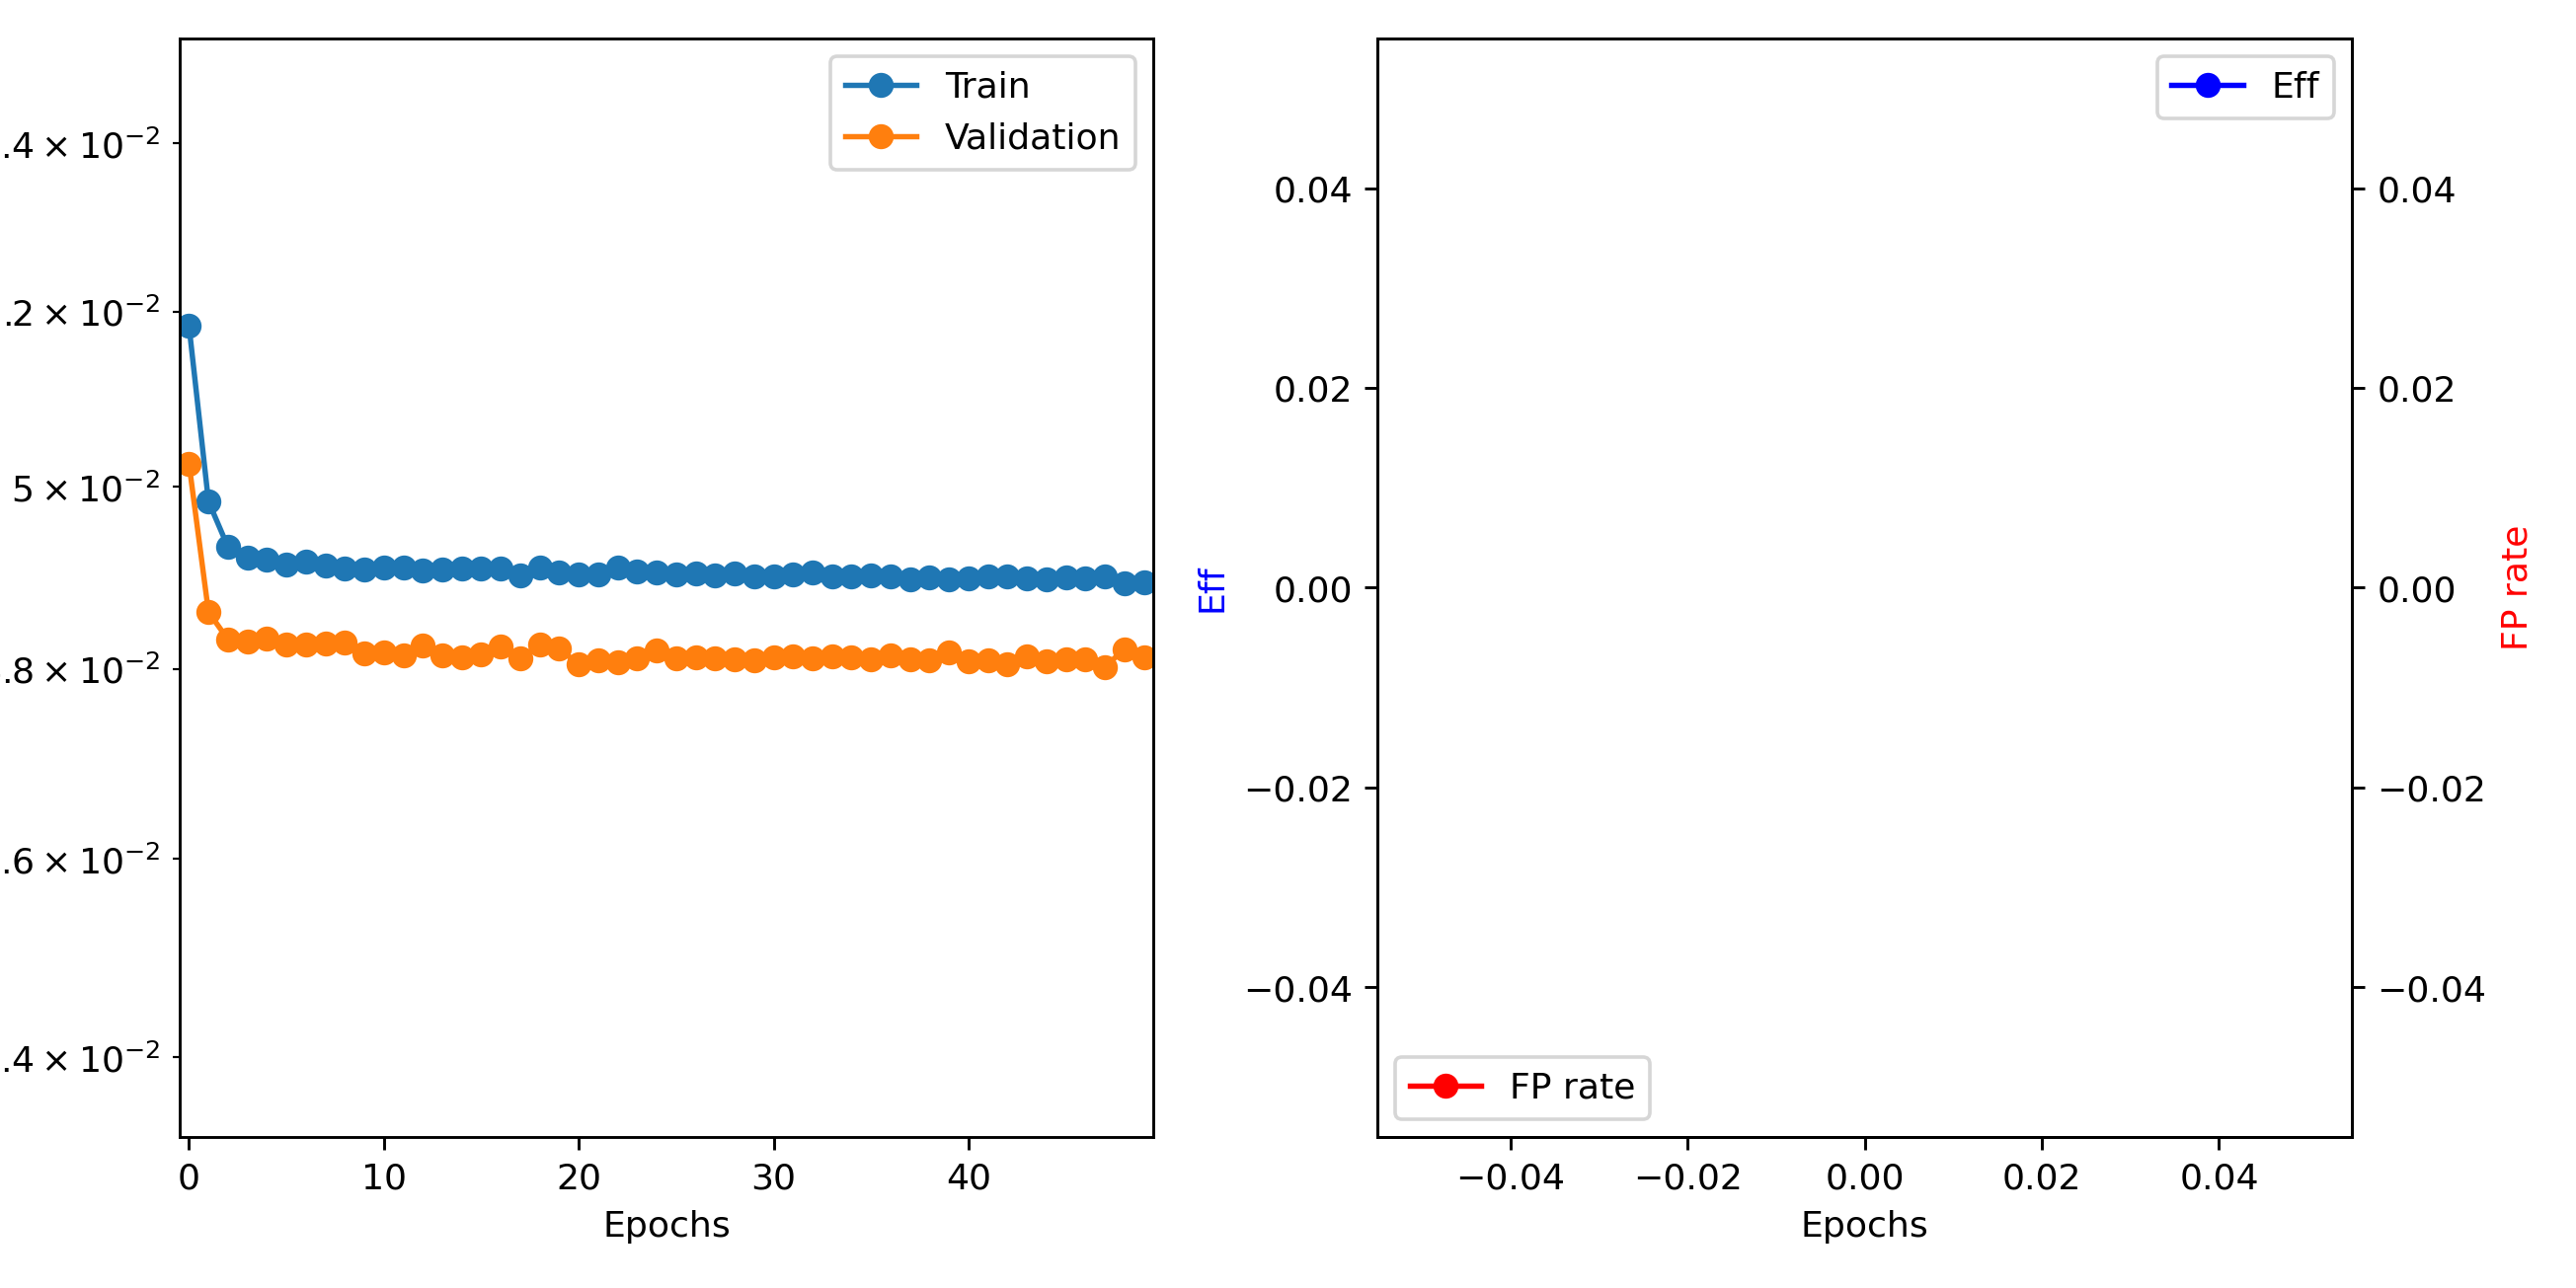

In [17]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [18]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
## for pandas version < 2.0.0 use (now obsolete) append method;
## for pandas version 2.0.0 and above use concatenation method;
## both methods are used here as some of us are using older versions
## of pandas with newer Pytorch (version 2.0 and above) and some
## are using newer versions of pandas [mds 230412] and this "upgrade"
## should fail to work for those using slightly different conda environments
    if (pd_major<2):
        results = results.append(pd.Series(result._asdict()), ignore_index=True)
    else:
    
        new_row = pd.DataFrame(result._asdict(),index=[0])
##      print('results to be concatenated = ',result)
##      print('pd.Series(result._asdict()) = ',pd.Series(result._asdict()))
##      print('results before concatenation = ',results)
        results = pd.concat([results,new_row], ignore_index=True)
##      print('results after concatenation = ',results)


    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 6968, val = 884


Epochs:   0%|                                                     | 0/50 [00:00<?, ?it/s, train=start, val=sta…

Number of batches: train = 6968, val = 884


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 0: train=0.0518393,  val=0.0502625, took 135.62 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 1: train=0.0498372,  val=0.0486174, took 153.79 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 2: train=0.049331,  val=0.0483187, took 140.36 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 3: train=0.0492109,  val=0.0483013, took 124.45 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 4: train=0.0491861,  val=0.048325, took 123.84 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 5: train=0.0491333,  val=0.0482688, took 127.99 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 6: train=0.0491672,  val=0.0482597, took 130.02 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 7: train=0.0491306,  val=0.0482732, took 129.49 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 8: train=0.0490938,  val=0.0482898, took 126.87 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 9: train=0.0490774,  val=0.0481725, took 130.59 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 10: train=0.0491022,  val=0.0481759, took 127.9 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 11: train=0.0491093,  val=0.0481458, took 127.82 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 12: train=0.0490684,  val=0.0482522, took 126.52 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 13: train=0.049082,  val=0.0481445, took 126.37 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 14: train=0.0490983,  val=0.0481296, took 127.77 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 15: train=0.0490986,  val=0.048157, took 127.3 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 16: train=0.0490899,  val=0.0482478, took 129.8 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 17: train=0.0490195,  val=0.04811, took 132.57 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 18: train=0.0491094,  val=0.0482687, took 133.36 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 19: train=0.0490489,  val=0.0482216, took 129.98 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 20: train=0.049025,  val=0.0480479, took 131.41 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 21: train=0.049032,  val=0.0480903, took 130.43 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 22: train=0.0490997,  val=0.0480683, took 127.71 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 23: train=0.0490619,  val=0.0481182, took 130.68 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 24: train=0.049051,  val=0.0482023, took 126.99 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 25: train=0.0490298,  val=0.0481202, took 130.24 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 26: train=0.0490444,  val=0.0481263, took 131.38 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 27: train=0.0490168,  val=0.048117, took 126.13 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 28: train=0.0490355,  val=0.0481075, took 128.46 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 29: train=0.0490086,  val=0.0480957, took 126.88 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 30: train=0.049012,  val=0.0481278, took 128.35 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 31: train=0.0490267,  val=0.0481339, took 130.42 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 32: train=0.049045,  val=0.0481124, took 125.05 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 33: train=0.0490061,  val=0.0481374, took 122.49 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 34: train=0.0490057,  val=0.0481227, took 129.19 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 35: train=0.0490156,  val=0.0481096, took 129.85 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 36: train=0.0490052,  val=0.0481519, took 129.93 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 37: train=0.0489764,  val=0.048104, took 125.48 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 38: train=0.0489975,  val=0.0480959, took 130.45 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 39: train=0.0489778,  val=0.0481753, took 127.72 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 40: train=0.0489803,  val=0.0480783, took 130.11 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 41: train=0.0490052,  val=0.0480954, took 128.67 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 42: train=0.0490018,  val=0.0480486, took 131.87 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 43: train=0.0489818,  val=0.0481326, took 124.47 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 44: train=0.0489735,  val=0.048081, took 128.59 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 45: train=0.0489977,  val=0.0481079, took 123.86 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 46: train=0.0489833,  val=0.0481032, took 131.39 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 47: train=0.0490064,  val=0.048023, took 128.13 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 48: train=0.048932,  val=0.0482133, took 130.73 s


Training:   0%|                                                            | 0/6968 [00:00<?, ?it/s, train=sta…

Epoch 49: train=0.0489446,  val=0.0481228, took 126.91 s


Go ahead and save the final model (even though it was also saved above):

In [19]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [20]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/tmp/ipykernel_132736/3721022134.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block0_values] [items->Index(['epoch'], dtype='object')]

  results.to_hdf(f'{name}_stats.hdf5', 'results')


Save the plot above:

<IPython.core.display.Javascript object>


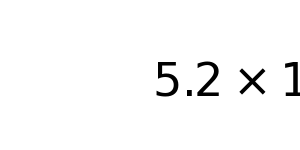

In [21]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [22]:
##quit()
